# Using arbirary (black box) likelihood functions

HSSM also supports "black box" (non-differentiable) likelihood functions, in which case a sampler that does not require likelihood functions to be differentiable will be used.

The following example illustrates how to use a `ddm` analytical likelihood function written in Cython as a "black box" likelihood function with HSSM.

In [1]:
import arviz as az
import bambi as bmb
import hssm
import numpy as np
import pandas as pd
import ssms

import hddm_wfpt

## Simulating a dataset
-  `dataset` passed to the model should always include 'rt' and 'response'.
-  `dataset` should be a pandas dataframe.

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,3.712950,1.0
1,3.372974,1.0
2,2.029016,1.0
3,1.316993,1.0
4,0.834999,1.0
...,...,...
995,2.039016,1.0
996,1.523992,1.0
997,2.785017,1.0
998,1.221994,-1.0


In [3]:
def pdf_sv(data, v, a, z, t, err=1e-4):
    data = data[:, 0] * data[:, 1]
    return hddm_wfpt.wfpt.pdf_array(data, v, 0, a, z, 0, t, 0, err, 1)

In [4]:
model = hssm.HSSM(
    data=dataset,
    model="ddm",
    loglik=pdf_sv,
    loglik_kind="blackbox",
    model_config={
        "bounds": {
            "v": (-10.0, 10.0),
            "a": (2.0, 4.0),
            "z": (0.0, 1.0),
        }
    },
    t=bmb.Prior("Uniform", lower=0.0, upper=0.7, initval=0.1),
)

In [5]:
sample = model.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [t]
>Slice: [z]
>Slice: [a]
>Slice: [v]


/var/folders/9x/cjrfyjd9443d4_0wt9qw8fhh0000gq/T/ipykernel_21966/1359982028.py:3: RuntimeWarning: divide by zero encountered in log
  return hddm_wfpt.wfpt.pdf_array(data, v, 0, a, z, 0, t, 0, err, 1)
/var/folders/9x/cjrfyjd9443d4_0wt9qw8fhh0000gq/T/ipykernel_21966/1359982028.py:3: RuntimeWarning: divide by zero encountered in log
  return hddm_wfpt.wfpt.pdf_array(data, v, 0, a, z, 0, t, 0, err, 1)
/var/folders/9x/cjrfyjd9443d4_0wt9qw8fhh0000gq/T/ipykernel_21966/1359982028.py:3: RuntimeWarning: divide by zero encountered in log
  return hddm_wfpt.wfpt.pdf_array(data, v, 0, a, z, 0, t, 0, err, 1)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [6]:
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.484,0.021,0.444,0.521,0.001,0.000,1262.0,1732.0,1.0
z,0.501,0.012,0.478,0.524,0.000,0.000,1293.0,1441.0,1.0
a,3.072,0.052,2.976,3.168,0.001,0.001,1637.0,2298.0,1.0
v,0.479,0.029,0.425,0.534,0.001,0.001,1568.0,2206.0,1.0


array([[<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

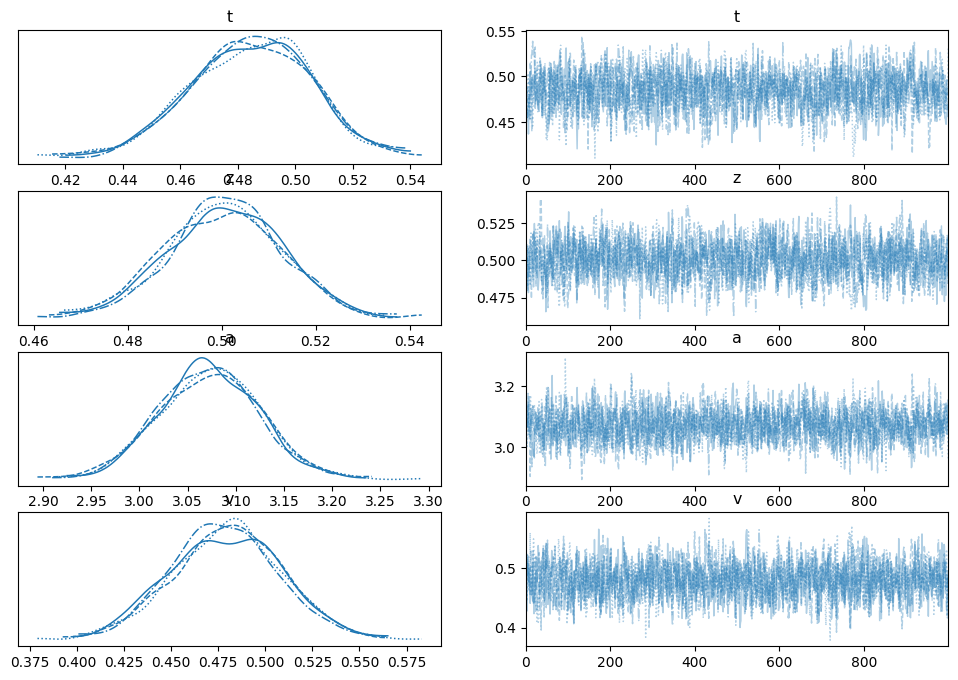

In [7]:
az.plot_trace(sample)